# Model selection for PLS, di-PLS and mdi-PLS models

### Load modules

In [60]:
# --- system modules

import sys
import datetime
import os


# --- numerical modules

import numpy as np
import pandas as pd


# --- model building

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


# --- diPLS

import functions as fct
import dipals as ml
import utils 


# --- visualization and data modules
import matplotlib as mtply
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


plt.style.use("ggplot")
plt.rcParams.update({'font.size': 20})

### Load data

In [61]:
data_url = "NAnderson2020MendeleyMangoNIRData.csv"

data_raw = pd.read_csv(data_url,sep = ",", decimal = ".")
# data_raw.describe(include = 'all')

### Specify source and target domains

Here the common cultivars for the 4 seasons are Caly, KP, HG, R2E2, therefore we keep those 4 cultivars. Cultivar Caly is kept in the source domain with season 1. The other cultivars are taken in the target domains for seasons 1,2 and 3.
The test set is called "Val Ext" and it contains data of season 4 and we take all the other conditions.

In [62]:
sou_filter = (data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "Caly")

tar_filters = []
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==1) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Tuning") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==2) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "KP"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "HG"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Hard Green") & (data_raw["Cultivar"] == "R2E2"))
tar_filters.append((data_raw["Season"]==3) &  (data_raw["Set"] == "Cal") & (data_raw["Region"] == "NT") & (data_raw["Type"] == "Ripen") & (data_raw["Cultivar"] == "KP"))


# season 4
tar_test_filter = (data_raw["Set"]=="Val Ext") & (data_raw["Region"] == "NT") & ((data_raw["Type"] == "Hard Green") | (data_raw["Type"] == "Ripen") ) & ((data_raw["Cultivar"] == "Caly") | (data_raw["Cultivar"] == "KP") | (data_raw["Cultivar"] == "HG") | (data_raw["Cultivar"] == "R2E2"))

# data sizes
#print(sou_filter.sum(), [tt_filter.sum() for tt_filter in tar_filters],tar_test_filter.sum())

In [63]:
# Get data sets for each domain

data_sou = data_raw.loc[sou_filter]
data_tar_list = []

for tt_filter in tar_filters:
    
    data_tar_list.append(data_raw.loc[tt_filter])
    
data_tar_test = data_raw.loc[tar_test_filter]

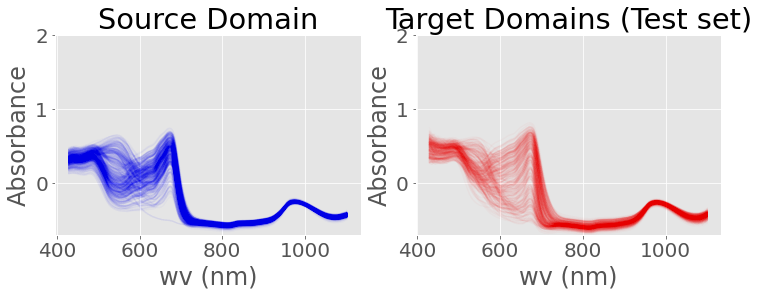

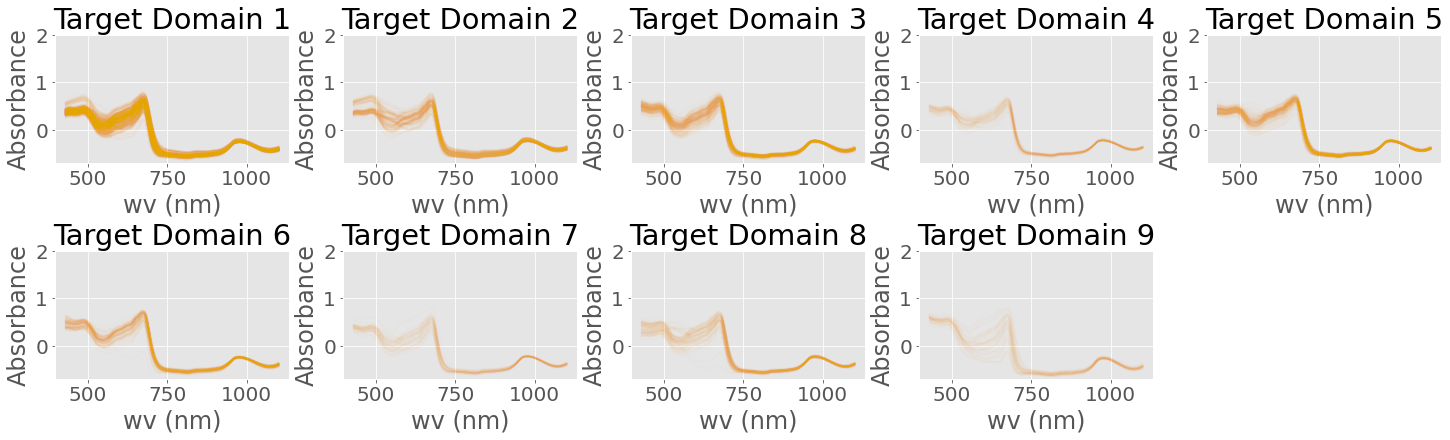

In [64]:
# Get matrices for each domain

wv_range_selected = np.arange(40,265) # 430-1100 nm

Xsou_cal = np.array(data_sou.iloc[:,17:-14])[:,wv_range_selected]
Ysou_cal = np.array(data_sou.iloc[:,8:9])

Xt_list = []

for data_tar in data_tar_list:
    
    Xt_list.append(np.array(data_tar.iloc[:,17:-14])[:,wv_range_selected])


Xtar_test = np.array(data_tar_test.iloc[:,17:-14])[:,wv_range_selected]
Ytar_test = np.array(data_tar_test.iloc[:,8:9])


wv_range = np.array(data_sou.columns[17:-14]).astype(np.float64)[wv_range_selected]


# spectral signals from each domain

ymin = -0.7
ymax = 2


fig, axs = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)

axs[0].plot(wv_range,Xsou_cal.T,c="blue", alpha=0.01)
axs[0].set_ylim(ymin, ymax)
axs[0].set_title("Source Domain")
axs[0].set_xlabel("wv (nm)")
axs[0].set_ylabel("Absorbance")

axs[1].plot(wv_range,Xtar_test.T,c="red", alpha=0.01)
axs[1].set_ylim(ymin, ymax)
axs[1].set_title("Target Domains (Test set)")
axs[1].set_xlabel("wv (nm)")
axs[1].set_ylabel("Absorbance")


plt.show()

fig, axs = plt.subplots(2, 5, figsize=(20,6), constrained_layout=True)
k = 0
for i in range(2):
    for j in range(5):        
        if k < 9:
            axs[i,j].plot(wv_range,Xt_list[k].T,c="orange", alpha=0.01)
            axs[i,j].set_ylim(ymin, ymax)
            axs[i,j].set_title("Target Domain {:d}".format(k+1))
            axs[i,j].set_xlabel("wv (nm)")
            axs[i,j].set_ylabel("Absorbance")
            
            k += 1


axs[-1,-1].axis('off')

plt.show()


### Model selection

In [65]:
X = Xsou_cal.copy()
Xs = X.copy()
Y = Ysou_cal.copy()

# For mdipls
target_domains = Xt_list.copy()

# For dipls with concatenation
Xtar_concat = np.concatenate(Xt_list, axis = 0) 
target_domains_concat = [Xtar_concat]


#### Cross-validation (this might take a while)

In [66]:
lv_range = np.arange(1,26)
lambda_range = np.array([0,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8, 1e9, 1e10, 1e11])

mdipls_rmsecv = np.zeros((lambda_range.shape[0],lv_range.shape[0]))
dipls_rmsecv = np.zeros((lambda_range.shape[0],lv_range.shape[0]))

Y_cv_mdipls_dict = {}
Y_cv_dipls_dict = {}

for li in range(lambda_range.shape[0]):

    print(li)

    Y_cv_mdipls = utils.cross_val_predict_mdipls(X, Y, Xs, target_domains, max_lv = np.amax(lv_range), lamb = lambda_range[li], n_splits_cv = 10)
    Y_cv_mdipls_dict[li] = Y_cv_mdipls.copy()

    Y_cv_dipls = utils.cross_val_predict_mdipls(X, Y, Xs, target_domains_concat,  max_lv = np.amax(lv_range), lamb = lambda_range[li], n_splits_cv = 10)
    Y_cv_dipls_dict[li] = Y_cv_dipls.copy()

    
print("done") 

0
1
2
3
4
5
6
7
8
9
10
11
done


In [67]:
for li in range(lambda_range.shape[0]):
     
    for lvi in range(lv_range.shape[0]):


        Y_cv_mdipls = Y_cv_mdipls_dict[li][:,lvi]
        mdipls_rmsecv[li,lvi] = utils.performance_measures(Y,Y_cv_mdipls)[0]


        Y_cv_dipls = Y_cv_dipls_dict[li][:,lvi]
        dipls_rmsecv[li,lvi] = utils.performance_measures(Y,Y_cv_dipls)[0]

print("done")

done


#### RMSECV vs regularization parameter $\lambda$

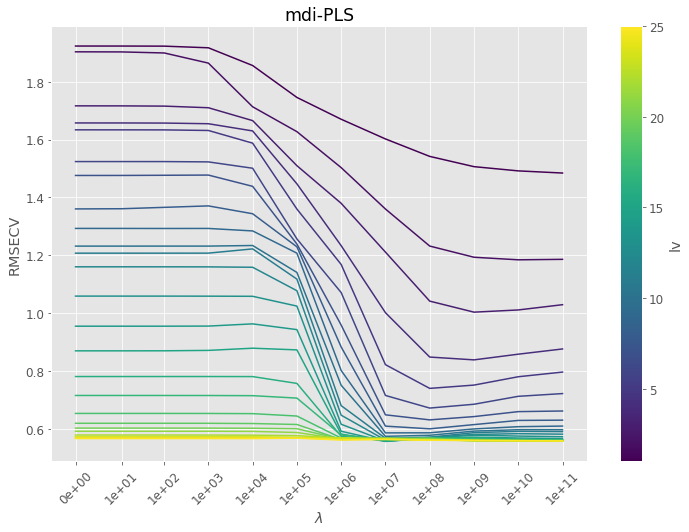

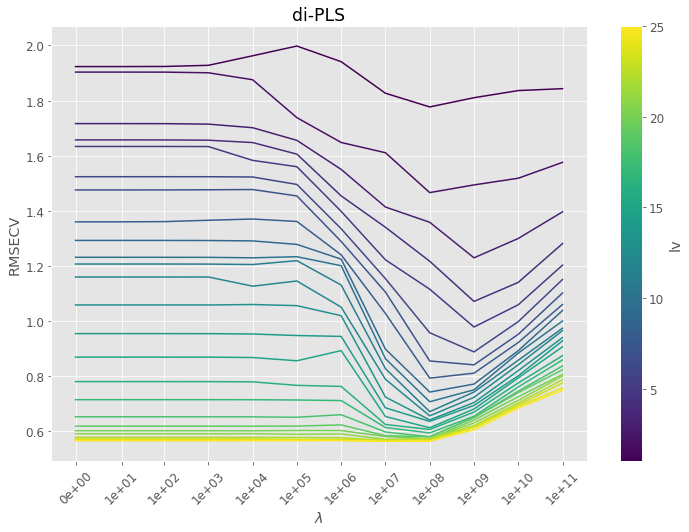

In [68]:
color_var = lv_range.copy()
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.viridis
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

plt.rcParams.update({'font.size': 12})
for rmsecv_name,matrix_rmsecv in {"mdi-PLS": mdipls_rmsecv, "di-PLS": dipls_rmsecv}.items():

    fig, ax = plt.subplots(figsize = (12, 8))
    for lvi in range(lv_range.shape[0]):
        color_tuple = s_m.to_rgba(color_var[lvi])
        cax = ax.plot(np.log(lambda_range+1), matrix_rmsecv[:,lvi], color = color_tuple)
    cbar = fig.colorbar(s_m, label = "lv")
    # cbar.set_ticks(color_var[::1])
    # cbar.set_ticklabels(["{:.0e}".format(i) for i in lambda_range[::1]])
    ax.set_xticks(np.log(lambda_range+1))
    ax.set_xticklabels(["{:.0e}".format(i) for i in lambda_range], rotation=45)

    ax.set_title(rmsecv_name)
    ax.set_xlabel("$\lambda$")
    ax.set_ylabel("RMSECV")
    fig.savefig("../figures/mango_{}_rmsecv_lambda.png".format(rmsecv_name))
    # ax.grid()
    plt.show()


#### Choice of the regularization parameter $\lambda$
From the above plots it can be seen that for mdi-PLS and di-PLS the RMSECV reaches its minimum around $\lambda=1e7$ and $1e8$, respectively (for most LVs).

#### RMSECV vs #LVs

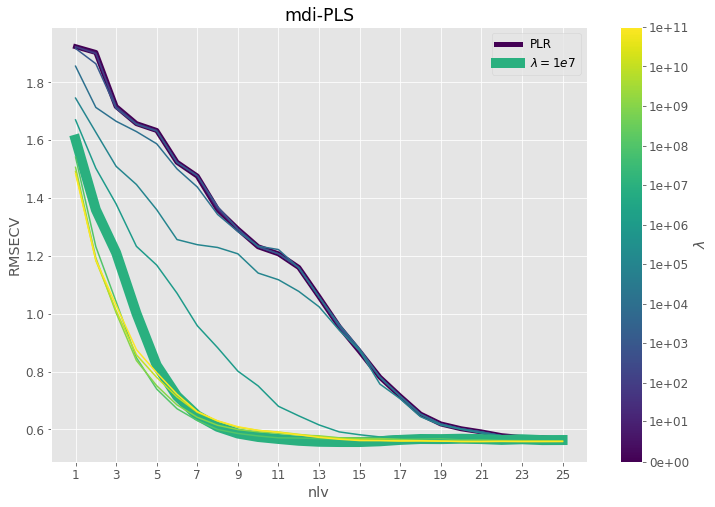

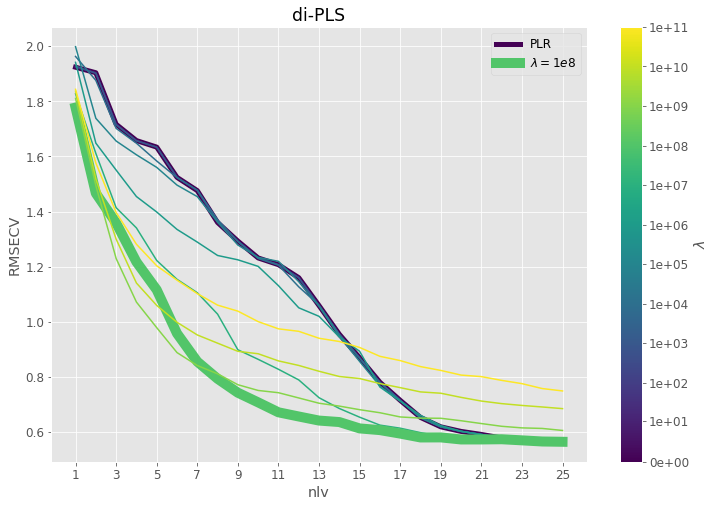

In [69]:
color_var = np.log(lambda_range+1).copy()
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.viridis
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)


for rmsecv_name,matrix_rmsecv in {"mdi-PLS": mdipls_rmsecv, "di-PLS": dipls_rmsecv}.items():

    fig, ax = plt.subplots(figsize = (12, 8))
    for li in range(lambda_range.shape[0]):
        color_tuple = s_m.to_rgba(color_var[li])
        cax = ax.plot(np.arange(1, lv_range[-1]+1), matrix_rmsecv[li,:], color = color_tuple)
        if li==0:
            cax = ax.plot(np.arange(1, lv_range[-1]+1), matrix_rmsecv[li,:], color = color_tuple, linewidth=5, label = "PLR")     
            ax.legend()
        if li==7 and rmsecv_name=="mdi-PLS":
            cax = ax.plot(np.arange(1, lv_range[-1]+1), matrix_rmsecv[li,:], color = color_tuple, linewidth=10, label = "$\lambda=1e7$")     
            ax.legend()
        if li==8 and rmsecv_name=="di-PLS":
            cax = ax.plot(np.arange(1, lv_range[-1]+1), matrix_rmsecv[li,:], color = color_tuple, linewidth=10, label = "$\lambda=1e8$")            
            ax.legend()
    cbar = fig.colorbar(s_m, label = "$\lambda$")
    cbar.set_ticks(color_var[::1])
    cbar.set_ticklabels(["{:.0e}".format(i) for i in lambda_range[::1]])
    ax.set_xticks(np.arange(1, lv_range[-1]+1,2))
    ax.set_title(rmsecv_name)
    ax.set_xlabel("nlv")
    ax.set_ylabel("RMSECV")
    fig.savefig("../figures/mango_{}_rmsecv.png".format(rmsecv_name))
    # ax.grid()
    plt.show()

#### Final choice of parameters

1. For lambda, the biggest change is selected (both methods happen at lambda = 1e7)
2. For lv, minimum non-significant change from minimum (next section). Lambda is fixed here

### Regression models
#### PLS

In [74]:
method = "PLS"

li = 0 # position of lambda = 0

# Choose final lv

chosen_lv_temp_position = np.argmin(mdipls_rmsecv[li,:])
Y_cv_pls =  Y_cv_mdipls_dict[li][:,chosen_lv_temp_position]
res_cv_min = (Y[:,0] - Y_cv_pls)**2
lv_position = chosen_lv_temp_position
non_stop = True
k=1 # Bonferroni correction factor to account for multiple comparisons

while non_stop:
    
    lv_position -= 1
    Y_cv_pls =  Y_cv_mdipls_dict[li][:,lv_position]   
    res_cv = (Y[:,0] - Y_cv_pls)**2
    ttest = stats.ttest_ind(res_cv.flatten(), res_cv_min.flatten(), equal_var = False, permutations = 1000, alternative = "greater", random_state = 957854125)
    #ttest = stats.ttest_rel(res_cv.flatten(), res_cv_min.flatten(), alternative = "greater")
    print(lv_position + 1, ttest)
    
    if (ttest.pvalue <= 0.05) or (lv_position == 0):
        non_stop = False

    k += 1
    
chosen_lv = lv_position + 1
print(method, "lv: ", chosen_lv)

24 Ttest_indResult(statistic=0.23476660645807743, pvalue=0.403)
23 Ttest_indResult(statistic=0.2667997546250666, pvalue=0.387)
22 Ttest_indResult(statistic=0.5688602546456585, pvalue=0.271)
21 Ttest_indResult(statistic=1.167069575263744, pvalue=0.125)
20 Ttest_indResult(statistic=1.6863007246957709, pvalue=0.051)
19 Ttest_indResult(statistic=2.4723559503743364, pvalue=0.006)
PLS lv:  19


In [73]:
method = "di-PLS"

li = 8 # position of lambda = 1e8

# Choose final lv

chosen_lv_temp_position = np.argmin(dipls_rmsecv[li,:])
Y_cv_dipls =  Y_cv_mdipls_dict[li][:,chosen_lv_temp_position]
res_cv_min = (Y[:,0] - Y_cv_dipls)**2
lv_position = chosen_lv_temp_position
non_stop = True
k=1 # Bonferroni correction factor to account for multiple comparisons

while non_stop:
    
    lv_position -= 1
    Y_cv_dipls =  Y_cv_dipls_dict[li][:,lv_position]   
    res_cv = (Y[:,0] - Y_cv_dipls)**2
    ttest = stats.ttest_ind(res_cv.flatten(), res_cv_min.flatten(), equal_var = False, permutations = 1000, alternative = "greater", random_state = 957854125)
    #ttest = stats.ttest_rel(res_cv.flatten(), res_cv_min.flatten(), alternative = "greater")
    print(lv_position + 1, ttest)
    
    if (ttest.pvalue <= 0.05) or (lv_position == 0):
        non_stop = False

    k += 1
    
chosen_lv = lv_position + 1
print(method, "lv: ", chosen_lv)

24 Ttest_indResult(statistic=0.24828671215653397, pvalue=0.407)
23 Ttest_indResult(statistic=0.4376432910742906, pvalue=0.324)
22 Ttest_indResult(statistic=0.6222195981182219, pvalue=0.265)
21 Ttest_indResult(statistic=0.5866269978374311, pvalue=0.277)
20 Ttest_indResult(statistic=0.5767156109316405, pvalue=0.278)
19 Ttest_indResult(statistic=0.9174523939899024, pvalue=0.181)
18 Ttest_indResult(statistic=0.9001351337061939, pvalue=0.179)
17 Ttest_indResult(statistic=1.5453504507406655, pvalue=0.062)
16 Ttest_indResult(statistic=2.0918181651392564, pvalue=0.019)
di-PLS lv:  16


In [75]:
method = "mdi-PLS"

li = 7 # position of lambda = 1e7

# Choose final lv

chosen_lv_temp_position = np.argmin(mdipls_rmsecv[li,:])
Y_cv_mdipls =  Y_cv_mdipls_dict[li][:,chosen_lv_temp_position]
res_cv_min = (Y[:,0] - Y_cv_mdipls)**2
lv_position = chosen_lv_temp_position
non_stop = True
k=1 # Bonferroni correction factor to account for multiple comparisons

while non_stop:
    
    lv_position -= 1
    Y_cv_mdipls =  Y_cv_mdipls_dict[li][:,lv_position]   
    res_cv = (Y[:,0] - Y_cv_mdipls)**2
    ttest = stats.ttest_ind(res_cv.flatten(), res_cv_min.flatten(), equal_var = False, permutations = 1000, alternative = "greater",  random_state = 957854125)
    #ttest = stats.ttest_rel(res_cv.flatten(), res_cv_min.flatten(), alternative = "greater")
    print(lv_position + 1, ttest)
    
    if (ttest.pvalue <= 0.05/k) or (lv_position == 0):
        non_stop = False
    
chosen_lv = lv_position + 1
print(method, "lv: ", chosen_lv)

14 Ttest_indResult(statistic=0.0022824807265033674, pvalue=0.486)
13 Ttest_indResult(statistic=0.042202224776539385, pvalue=0.476)
12 Ttest_indResult(statistic=0.1987630142485707, pvalue=0.415)
11 Ttest_indResult(statistic=0.4843268201405304, pvalue=0.315)
10 Ttest_indResult(statistic=0.7991963130306621, pvalue=0.21)
9 Ttest_indResult(statistic=1.340964156793057, pvalue=0.085)
8 Ttest_indResult(statistic=2.3644490908363953, pvalue=0.009)
mdi-PLS lv:  8
